In [ ]:
from tqdm import tqdm
from textblob import TextBlob
import re
from scipy.stats import anderson
from scipy.stats import ttest_ind

# To be verified: is all needed?
import pandas as pd
import numpy as np
import pickle
import json
import ast
from collections import Counter
import scipy.stats as stats
import sys
from pathlib import Path
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from scipy.sparse import load_npz, save_npz
from collections import defaultdict
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as smf


# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display, Markdown

# Detect root starting from this file or from notebook’s cwd
try:
    start_path = Path(__file__).resolve()
except NameError:
    start_path = Path.cwd()

root = start_path
while root != root.parent:
    # Check for any known project markers
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Sanity check — fallback if nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("⚠️ Project root not found — defaulting to current working directory")
    root = Path.cwd()

print(f"✅ Root folder detected at: {root}")

# Add project root to sys.path if not already
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
# utils
from src.utils.general_utils import *
#from src.utils.gui import plots_gui as pg
from src.utils.function_axis_1 import plot_global_vote_distribution
from src.utils.function_axis_1 import compute_funny_ranking
from src.utils.tf_idf_matrix import extract_documents, create_tf_idf_matrix, extract_terms_counts

# scripts
import src.scripts.descriptive_stats_tasks as dst
import src.scripts.axis1 as ax_one
from src.scripts.axis2 import *
from src.utils.paths import *


# models
from src.models.gender_analysis import GenderAnalysis
#from src.models.similarity_analysis import SimilarityModel, CaptionClustering, SimilarHumorAnalysis

%matplotlib inline

✅ Root folder detected at: /Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42


## Axis 1 – What Is Considered Funny

### 2.1.1 : Katia's wonderful work

#### a. Data preparation

In [10]:
stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH
with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)

dataA = data['dataA']

dfs_with_id = [
    df.assign(source_id=i)   # add columns with ID of original dataset 
    for i, df in enumerate(dataA)
]
dataAm2 = pd.concat(dfs_with_id, ignore_index=True)
dataAm2.sort_values(by='funny_score_scaled', ascending=False, inplace=True)
dataAm2_2=dataAm2.drop_duplicates() # necessary because some captions were duplicated on some dataframes 
results_blob = []

dataAm2_2 = dataAm2_2.reset_index().rename(columns={"index": "caption_id"})
for i, cap in tqdm(zip(dataAm2_2['caption_id'], dataAm2_2['caption']), total=len(dataAm2_2)):
    blob = TextBlob(cap)
    results_blob.append({
        'caption_id': i,
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity,
        'num_words': len(blob.words),
        'num_punct': len(re.findall(r'[^\w\s]', cap)),
        'num_repeats': len(re.findall(r'\b(\w+)\s+\1\b', cap.lower()))
    })

df_blob = pd.DataFrame(results_blob)

dataAm_rf = dataAm2_2.merge(df_blob, on="caption_id", how="inner")
dataAm_rf= dataAm_rf[dataAm_rf["num_words"]<80] # remove captions that were badly encoded
dataAm_rf

100%|██████████| 2292354/2292354 [03:36<00:00, 10605.14it/s]


,caption_id,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,funny_score_scaled,funny_group,source_id,polarity,subjectivity,num_words,num_punct,num_repeats
0,862178,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,36.70,100.000000,funny,153,0.00000,0.000000,4,1,0
1,452628,Mission accomplished. We will report that this...,2.998918,0.001083,924,0,1,923,34.13,95.262673,funny,88,0.28750,0.500000,14,3,0
2,1041265,Looks like you're already familiar with the si...,2.387410,0.005740,14726,1941,5211,7574,30.64,88.829493,funny,188,0.37500,0.500000,10,2,0
3,1048528,I just want to make sure 'mousse' isn't a typo.,2.354409,0.006038,14266,2078,5048,7126,29.57,86.857143,funny,189,0.50000,0.888889,11,4,0
4,934245,Is the salmon fresh?,2.338348,0.005993,14423,2164,5232,7027,29.14,86.064516,funny,168,0.30000,0.500000,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2292349,418100,They want to know if they can work remotely du...,1.000000,0.000158,6313,6313,0,0,-17.50,0.092166,not_funny,80,-0.10000,0.200000,12,0,0
2292350,418101,"Ever so subtly, Ed began to push his right win...",1.000000,0.000157,6377,6377,0,0,-17.52,0.055300,not_funny,80,-0.02381,0.517857,11,2,0
2292351,418102,I'm pretty sure I said 'hackers'.,1.000000,0.000157,6366,6366,0,0,-17.52,0.055300,not_funny,80,0.37500,0.944444,7,4,0
2292352,418103,I am concerned that this project could go sout...,1.000000,0.000157,6359,6359,0,0,-17.52,0.055300,not_funny,80,0.20000,0.600000,11,1,0


#### b. Comparison best and worth captions overall

Let's look at the ditribution of the funny score over the entire dataset.

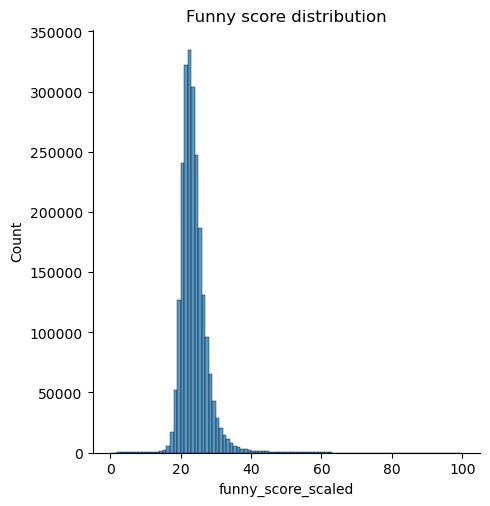

AndersonResult(statistic=np.float64(50595.25888574589), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(23.740472574965178), scale=np.float64(3.7631580153665776))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [13]:
sns.displot(dataAm_rf, x="funny_score_scaled", bins=100) 
plt.title("Funny score distribution")
plt.show()

result = anderson(dataAm_rf["funny_score_scaled"], dist='norm')
print(result)

We can see that distribution looks like normal but is actually not as anderson test is successfull, this is likely because we have a lot of data that can therefore grasp if the distribution deviate even a little bit from a normal pattern. Then to define our funny group we can retrieve by taking the higher and lower quantile which do not depend on the distribution.

In [14]:
# Anderson-Darling test
result = anderson(dataAm_rf["funny_score_scaled"], dist='norm')
print(result)

with open("anderson_test_results.txt", "w") as f:
    f.write(str(result))

AndersonResult(statistic=np.float64(50595.25888574589), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(23.740472574965178), scale=np.float64(3.7631580153665776))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


In [ ]:
low_threshold = dataAm_rf["funny_score_scaled"].quantile(0.0001)
high_threshold = dataAm_rf["funny_score_scaled"].quantile(0.9999)

print(f"Low threshold: {low_threshold}")
print(f"High threshold: {high_threshold}")
def assign_group(row, high_threshold, low_threshold):
    if row['funny_score_scaled'] >= high_threshold:
        return 'funny'
    elif row['funny_score_scaled'] <= low_threshold:
        return 'not_funny'
    else:
        return 'mid_funny'
dataAm_rf["funny_group3"] = dataAm_rf.apply(assign_group, axis=1, high_threshold=high_threshold, low_threshold=low_threshold)
dataAm_rf_filtered = dataAm_rf[dataAm_rf["funny_group3"] != 'mid_funny']

Low threshold: 3.473942857142859
High threshold: 66.78341013824885


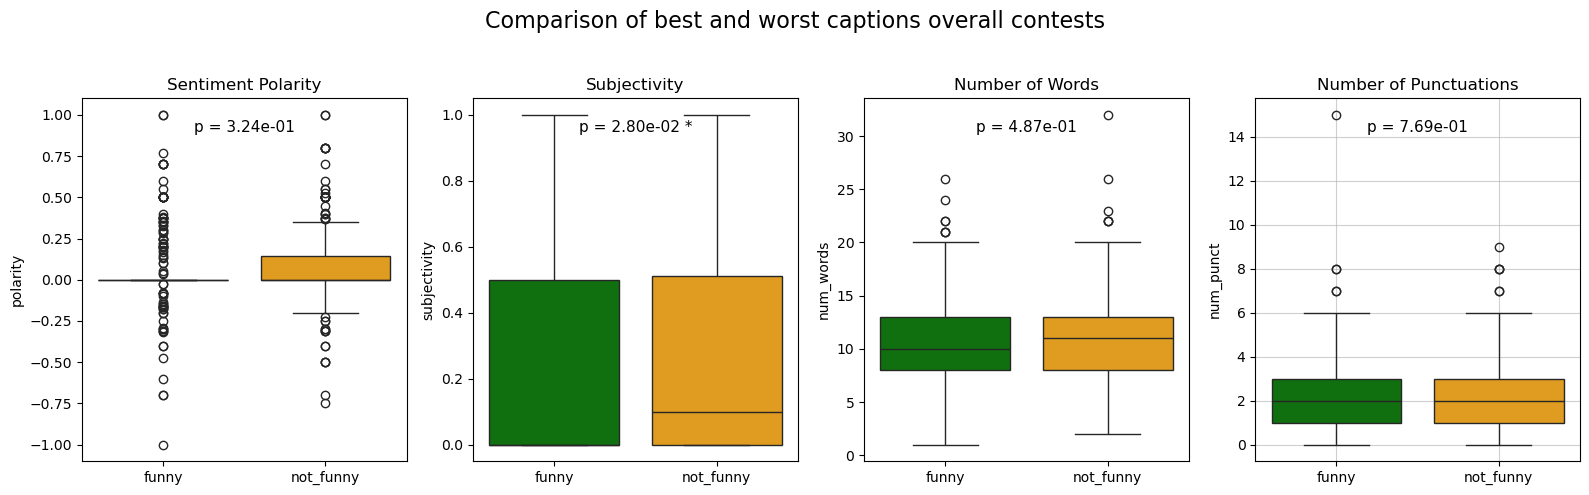

In [18]:
features = ['polarity', 'subjectivity', 'num_words', 'num_punct']
groups = ['funny', 'not_funny']
ax_one.plot_boxplot_static(
    dataAm_rf_filtered,
    columns_category="funny_group3",
    features=features,
    save_fig=False,
    title="funny_vs_not_funny"
)

In [20]:
features = ['polarity', 'subjectivity', 'num_words', 'num_punct']
for f in features:
    g1 = dataAm_rf_filtered.loc[dataAm_rf_filtered['funny_group3'] == 'funny', f]
    g2 = dataAm_rf_filtered.loc[dataAm_rf_filtered['funny_group3'] == 'not_funny', f]

    t_stat, p_val = ttest_ind(g1, g2, equal_var=False)
    if p_val < 0.05:
        print(f"For {f} varibale : T-statistic: {t_stat}, P-value: {p_val} => Reject null hypothesis")
    else:   
        print(f"For {f} varibale : T-statistic: {t_stat}, P-value: {p_val}")

For polarity varibale : T-statistic: -0.9876455797312343, P-value: 0.32384722101489305
For subjectivity varibale : T-statistic: -2.203730584159546, P-value: 0.028046283668570884 => Reject null hypothesis
For num_words varibale : T-statistic: -0.6963916935356878, P-value: 0.48653653043938894
For num_punct varibale : T-statistic: -0.29385975381677965, P-value: 0.7689983847291602


In [21]:
summary_df =dataAm_rf.groupby('funny_group3').agg(
    total_rows=("source_id", "count"),
    unique_caption=("source_id", "nunique")
)
summary_df.to_csv("plot_result/unique_caption_summary.csv")

As we can see, the “not funny” group is composed of captions originating from only four contests. This imbalance may influence our results by introducing a bias toward the specific themes or styles of these contests rather than reflecting general trends. To address this issue, we repeated the same analysis on another dataset containing the funniest and worst captions for each contests, in order to obtain a more representative overview across the entire set of contests.

#### c. Best and worth captions for each contest

In [22]:
idx_best = dataAm_rf.groupby("source_id")["funny_score_scaled"].idxmax()
idx_worst = dataAm_rf.groupby("source_id")["funny_score_scaled"].idxmin()
df_best = dataAm_rf.loc[idx_best].copy()
df_best["caption_type"] = "best"

df_worst = dataAm_rf.loc[idx_worst].copy()
df_worst["caption_type"] = "worst"
df_combined = pd.concat([df_best, df_worst], ignore_index=True)

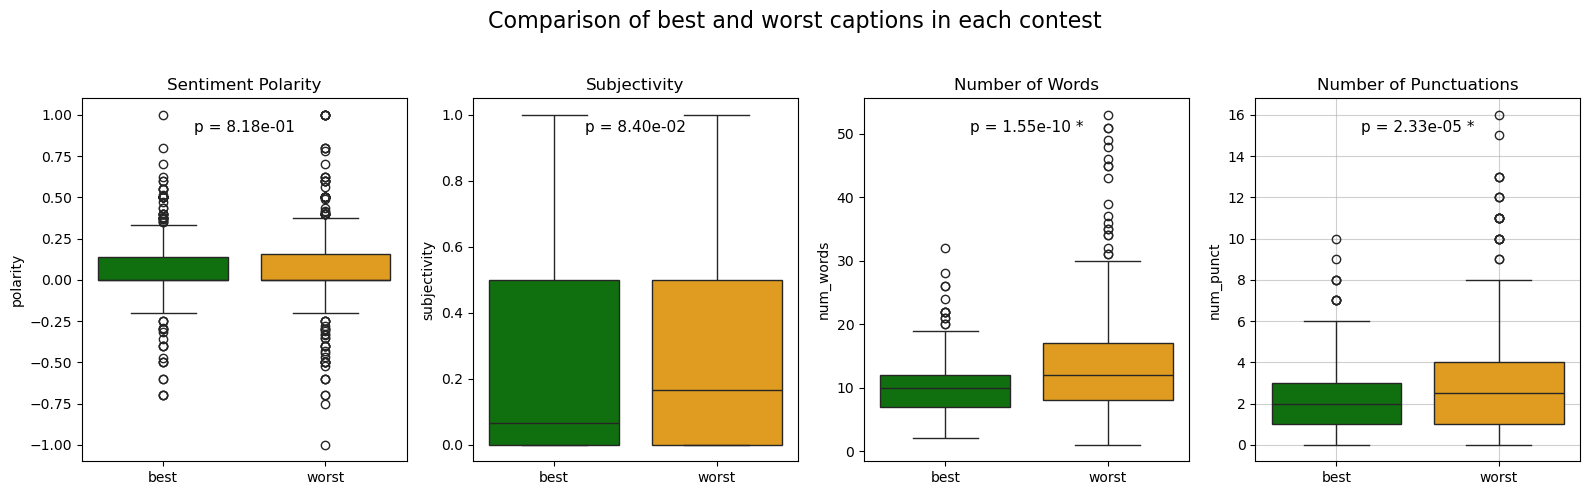

In [24]:
ax_one.plot_boxplot_static(
    df_combined,
    columns_category="caption_type",
    features=features,
    save_fig=False,
    title="best_vs_worst"
)

In [25]:
# Same plot but interactive for the website
ax_one.plot_boxplot_interactive(dataAm_rf_filtered, "funny_group3", features, title="funny_vs_not_funny")
ax_one.plot_boxplot_interactive(df_combined, "caption_type", features, title="funny_vs_not_funny")

#### d. Find very best and worst caption for website

In [26]:
best = dataAm_rf[dataAm_rf["funny_score_scaled"]==100]
worth = dataAm_rf[dataAm_rf["funny_score_scaled"]==0]

best_worth_df = pd.concat([best, worth], ignore_index=True)
display(best_worth_df)

best_contest = absolute_index2contest_index(best.iloc[0]["source_id"])
contest_worth = absolute_index2contest_index(worth.iloc[0]["source_id"])

path_worth = os.path.join( f"{root}/data/newyorker_caption_contest_virgin/images/", f"{contest_worth}.jpg")
path_best = os.path.join( f"{root}/data/newyorker_caption_contest_virgin/images/", f"{best_contest}.jpg")

#print(os.path.exists(path_best))

,caption_id,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,funny_score_scaled,funny_group,source_id,polarity,subjectivity,num_words,num_punct,num_repeats,funny_group3
0,862178,Lunch is on me.,2.518294,0.004085,25200,2183,7784,15232,36.70,100.0,funny,153,0.0,0.0,4,1,0,funny
1,418104,"We're not getting Shakespeare, but about every...",1.000000,0.000155,6467,6467,0,0,-17.55,0.0,not_funny,80,0.0,0.0,15,3,0,not_funny


## Funny prediction

In [31]:
df_combined.loc[:, "category"] = np.where(df_combined['caption_type'] == "best", '1', '0')

cols_to_standardize = ["num_words", "polarity", "subjectivity","num_repeats","num_punct"]
df = df_combined.copy()
for col in cols_to_standardize:
    df[col] = (df[col] - df[col].mean()) / df[col].std()
df["category"] = df["category"].astype(int)

mod = smf.logit(formula='category ~  num_words + polarity + subjectivity + num_repeats + \
                        num_punct ', data=df)
res = mod.fit()
print(res.summary())
summary_text = res.summary().as_text()

with open("logit_summary.txt", "w") as f:
    f.write(summary_text)

Optimization terminated successfully.
         Current function value: 0.662540
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               category   No. Observations:                  768
Model:                          Logit   Df Residuals:                      762
Method:                           MLE   Df Model:                            5
Date:                Sat, 20 Dec 2025   Pseudo R-squ.:                 0.04416
Time:                        18:00:16   Log-Likelihood:                -508.83
converged:                       True   LL-Null:                       -532.34
Covariance Type:            nonrobust   LLR p-value:                 5.650e-09
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0238      0.075     -0.317      0.751      -0.171       0.123
num_words       -0.5159